In [3]:
from torchvision import datasets
train_dataset = datasets.CIFAR10(
    "./data/cifar",
    train=True, 
    download=True
)

Files already downloaded and verified


In [4]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def get_train_idxs(dataset, num_users, num_items, alpha):
    labels = dataset.targets
    
    # Collect idxs for each label
    idxs_labels = {i: set() for i in range(10)}
    for idx, label in enumerate(labels):
        idxs_labels[label].add(idx)
    

    # 10 labels
    class_dist = np.random.dirichlet(alpha=[alpha for _ in range(10)], size=num_users)
    class_dist = (class_dist * num_items).astype(int)

    for _class, class_num in enumerate(class_dist.T.sum(axis=1)):
        assert class_num < len(idxs_labels[_class]), "num_items must be smaller"
    
    
    dict_users = {i: set() for i in range(num_users)}
    dists = {i: [0 for j in range(10)] for i in range(num_users)}
    
    for client_id, client_dist in enumerate(class_dist):
        for _class, num in enumerate(client_dist):
            sample_idxs = idxs_labels[_class]
            dists[client_id][_class] += num
            
            sampled_idxs = set(np.random.choice(list(sample_idxs), size=num, replace=False)) 
            # accumulate
            dict_users[client_id].update(sampled_idxs)
            
            # exclude assigned idxs
            idxs_labels[_class] = sample_idxs - sampled_idxs
            
    for i, data_idxs in dict_users.items():
        dict_users[i] = list(data_idxs)
    

    
    # for client_id, dist in dists.items():
    #     plt.figure(client_id)
    #     plt.title(f"client {client_id} class distribution")
    #     plt.xlabel("class")
    #     plt.ylabel("num items")
    #     plt.bar(range(10), dist, label=client_id)
    #     plt.savefig(f"./alpha/client_{client_id}_{sum(dist)}_{alpha}_{num_users}.png")
    #     plt.clf()
    
    
    return dict_users, dists

In [53]:
dict_users, dists = get_train_idxs(train_dataset, 5, 100, 10000)

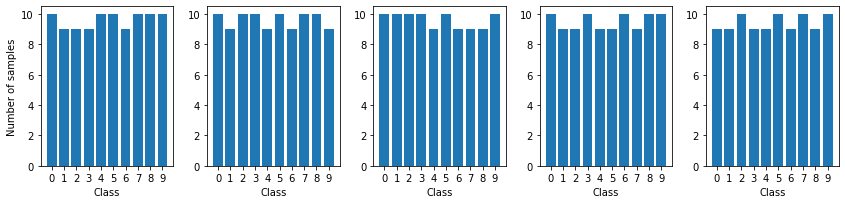

In [54]:
plt.figure(figsize=(12, 3))

for client_id, dist in dists.items():
    plt.subplot(1, 5, client_id+1)
    plt.tight_layout()
    plt.xticks(range(10))
    plt.bar(range(10), dist, label=client_id)
    if client_id == 0:
        plt.ylabel("Number of samples")
    plt.xlabel("Class")

plt.savefig("alpha10000.png")